**Created by Sanskar Hasija**

**Feedback Based Rating Predictions**

**18 OCTOBER 2021**


# <center> FEEDBACK BASED RATING PREDICTIONS </center>

## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. NN-LSTM Model](#lstm) ##
## [5. Comparison with other Models](#com) ##
###    [5.1 Logistic Regression](#lr) ###
###    [5.2 Naive Bayes](#nb) ###
###    [5.3 Support Vector Classifier(SVC)](#sv) ###
###    [5.4 Random Forest Classifier](#rf) ###
###    [5.5 XGB Classifier](#xg) ###
## [6. Performance Metrics Comparision](#per) ##


<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
input_dir = "../input/brazilian-ecommerce/olist_order_reviews_dataset.csv"
 

# HYPERPARAMETERS
RANDOM_STATE = 12
TRAIN_SPLIT = 0.80
OOV_TOK = "<OOV>"
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
BATCH_SIZE=128
EPOCHS=25
EARLY_STOPPING_CRITERIA=3
DROPOUT_P=0.4
LEARNING_RATE = 0.01
MOMENTUM =0.9
MAX_ITER = 10000
N_JOBS = 4



<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [3]:
data = pd.read_csv(input_dir)
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
def clean_data(data, column_text='review_comment_message', 
               column_score='review_score', 
               points_cut = [0, 2, 5], 
               classes = [0, 1]):
    
    df_bin = data
    df_bin = df_bin.dropna(subset=[column_text])
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text','label']]
    
    df_cat = data
    df_cat = df_cat.dropna(subset=[column_text])
    df_cat = df_cat.rename(columns={column_text: 'text' , column_score: 'label'})
    df_cat = df_cat[['text','label']]
    return df_bin ,df_cat


data_bin , data_cat = clean_data(data)

## Data Distribution among classes

In [5]:
fig = px.bar(x = np.unique(data_cat["label"]),
             y = [list(data_cat["label"]).count(i) for i in np.unique(data_cat["label"])] , 
             color = np.unique(data_cat["label"]) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Rating vs No of reviews ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [6]:
fig = px.bar(x = np.unique(data_bin["label"]), 
             y = [list(data_bin["label"]).count(i) for i in np.unique(data_bin["label"])] , 
             color=np.unique(data_bin["label"]) ,
             color_continuous_scale="Emrld")  
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Rating vs No of reviews ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

Due to data imbalanced in 5 different rating categories , we will work on binary classification problem instead. The output will be 0 and 1 representing NOT HAPPY and HAPPY respectively.

### WORDCLOUD

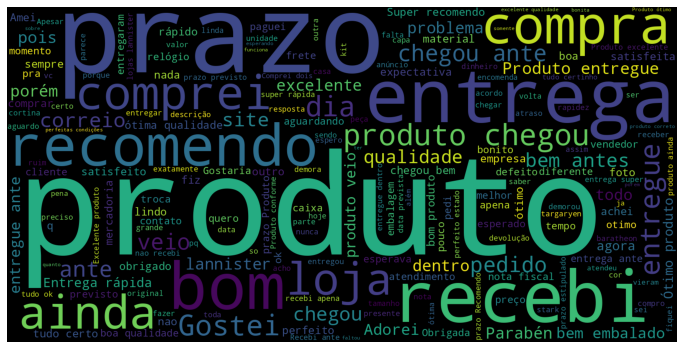

In [7]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(data_bin["text"]))
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [8]:
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    df_train = data.sample(frac = split_train, random_state = random_state)
    df_test = data.drop(df_train.index)

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for index, train in df_train.iterrows():
        X_train.append(str(train['text']))
        y_train.append(train['label'])
    
    for index, test in df_test.iterrows():
        X_test.append(str(test['text']))
        y_test.append(test['label'])
        
    y_train = np.array(y_train)
    y_test = np.array(y_test) 
    
    return X_train , y_train , X_test , y_test


X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [9]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(X_train)

def preprocess(X_train, X_test, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):

    training_sequences = tokenizer.texts_to_sequences(X_train)
    X_train_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)
    
    testing_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(testing_sequences,maxlen=max_length)
    
    return X_train_padded, X_test_padded

X_train, X_test = preprocess(X_train, X_test, MAX_LENGTH, VOCAB_SIZE)

<a id="lstm"></a>
# <center> NN-LSTM MODEL </center>

In [10]:
def create_model():
    
    input = tf.keras.Input(shape=(MAX_LENGTH))
    
    x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH)(input)
    x = tf.keras.layers.LSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(32)(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    
    x = tf.keras.layers.Dense(800, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    x = tf.keras.layers.Dense(400, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(input, output)

    return model

In [11]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

model = create_model()

model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(),
  optimizer= tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE , momentum=MOMENTUM),
  metrics=['accuracy']
)

model.summary()

2021-10-23 13:58:53.861039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 13:58:53.862055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 13:58:53.862698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 13:58:53.863477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 120, 32)           6272      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 800)               26400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0     

## Training LSTM Model

In [12]:
history = model.fit(x = X_train,
                    y = y_train, 
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks= [earlyStoppingCallback]
)
history = pd.DataFrame(history.history)

2021-10-23 13:58:56.716431: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2021-10-23 13:59:00.654052: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


257/257 [==============================] - 9s 16ms/step - loss: 0.5750 - accuracy: 0.7337 - val_loss: 0.5261 - val_accuracy: 0.7307
Epoch 2/25
257/257 [==============================] - 4s 14ms/step - loss: 0.5171 - accuracy: 0.7454 - val_loss: 0.5025 - val_accuracy: 0.7641
Epoch 3/25
257/257 [==============================] - 4s 14ms/step - loss: 0.4507 - accuracy: 0.7833 - val_loss: 0.5044 - val_accuracy: 0.7877
Epoch 4/25
257/257 [==============================] - 3s 14ms/step - loss: 0.3685 - accuracy: 0.8312 - val_loss: 0.3343 - val_accuracy: 0.8459
Epoch 5/25
257/257 [==============================] - 4s 14ms/step - loss: 0.3355 - accuracy: 0.8494 - val_loss: 0.3331 - val_accuracy: 0.8577
Epoch 6/25
257/257 [==============================] - 4s 15ms/step - loss: 0.3209 - accuracy: 0.8591 - val_loss: 0.3261 - val_accuracy: 0.8622
Epoch 7/25
257/257 [==============================] - 4s 14ms/step - loss: 0.3023 - accuracy: 0.8672 - val_loss: 0.2943 - val_accuracy: 0.8737
Epoch 8/25

## Visualizing Training Results

In [13]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] , 
            markers = True )
x.update_xaxes(title="Number of Epochs",
              rangeslider_visible = True)
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [14]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , 
            markers = True )
x.update_xaxes(title="Number of Epochs",
              rangeslider_visible = True)
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

## Evaluating LSTM model

In [15]:
y_preds_prob = model.predict(X_test, verbose=0)
y_preds = np.where(y_preds_prob> 0.5, 1, 0)
y_preds_prob = y_preds_prob[:, 0]
y_preds = y_preds[:, 0]

[loss,accuracy] = model.evaluate(X_test, y_test ,verbose = 0 )
print("Accuracy on Test Data :", accuracy*100 ,"%")
print(classification_report(y_test ,y_preds))

Accuracy on Test Data : 89.43257927894592 %
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2207
           1       0.94      0.91      0.93      5988

    accuracy                           0.89      8195
   macro avg       0.86      0.88      0.87      8195
weighted avg       0.90      0.89      0.90      8195



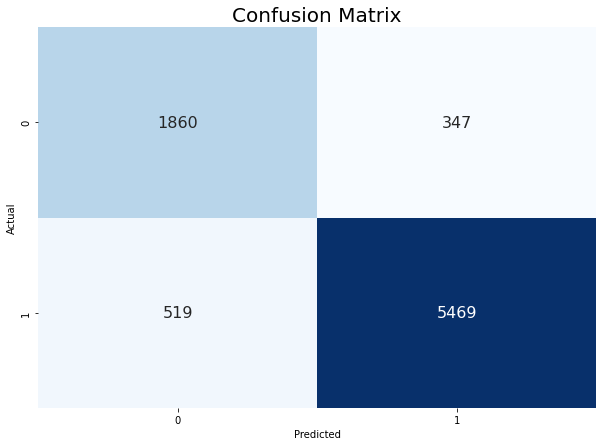

In [16]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=[0,1], index = [0,1])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix', fontsize = 20)

sns.set(font_scale=1.4)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

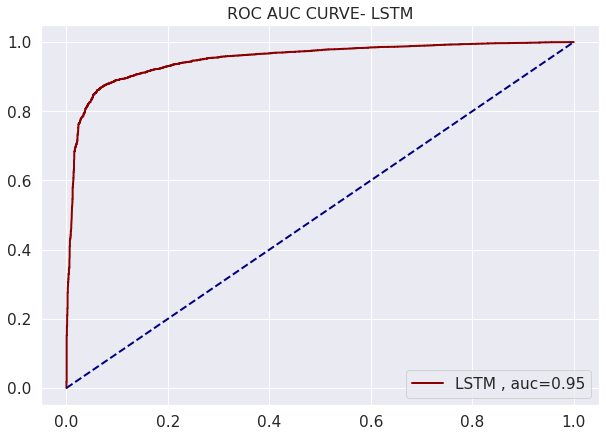

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds  = roc_curve(y_test, y_preds_prob)
auc = roc_auc_score(y_test, y_preds_prob)
plt.figure(figsize = (10,7))
plt.plot(fpr,tpr,color='darkred', lw=2, label="LSTM , auc="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC CURVE- LSTM', fontsize = 16)
plt.legend(loc=4)
plt.show()

<a id="com"></a>
# <center> COMPARISON WITH OTHER MODELS </center> 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

<a id="lr"></a>
# LOGISTIC REGRESSION

In [19]:
lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(X_test,y_test)*100,"%")

Model score on Training Data =  74.4920993227991 %
Model score on Testing Data =  73.32519829164124 %


<a id="nb"></a>
# NAIVE BAYES

In [20]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)
print("Model score on Training Data = ", nb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", nb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  74.55615886767129 %
Model score on Testing Data =  74.35021354484441 %


<a id="sv"></a>
# SUPPORT VECTOR CLASSIFIER (SVC)

In [21]:
svm = SVC(random_state=RANDOM_STATE , verbose = True)
svm.fit(X_train,y_train)
sv_preds = svm.predict(X_test)
print("Model score on Training Data = ", svm.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", svm.score(X_test,y_test)*100 ,"%")

[LibSVM].................
*..............................
*.
*
optimization finished, #iter = 47649
obj = -15046.581537, rho = -0.118732
nSV = 17350, nBSV = 14707
Total nSV = 17350
Model score on Training Data =  79.7907388200842 %
Model score on Testing Data =  74.49664429530202 %


<a id="rf"></a>
#  RANDOM FOREST CLASSIFIER

In [22]:
rfc = RandomForestClassifier(n_estimators = 100, random_state =RANDOM_STATE , n_jobs = N_JOBS)
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
print("Model score on Training Data = ", rfc.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", rfc.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  99.5790372765542 %
Model score on Testing Data =  78.40146430750458 %


<a id="xg"></a>
# XGBOOST CLASSIFIER

In [23]:
xgb = XGBClassifier(objective='binary:logistic' , 
                    use_label_encoder=False,  
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", xgb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  92.96870233664816 %
Model score on Testing Data =  83.01403294691885 %


<a id="per"></a>
# <center> PERFORMANCE METRICS COMPARISON </center> 

## Test Accuracies Comparison

In [24]:
results = pd.DataFrame(data  = [accuracy*100] , columns =["NN-Lstm"] , index = ["Test Accuracy"])
results['Logistic Regression'] = lr.score(X_test,y_test)*100
results['Naive Bayes'] = nb.score(X_test,y_test)*100
results['Support Vector Machine (SVM)'] = svm.score(X_test,y_test)*100
results['RandomForest Classifier'] = rfc.score(X_test,y_test)*100
results['XGBoost Classifier'] = xgb.score(X_test,y_test)*100
results = results.transpose()
x = px.line(data_frame= results, y = ["Test Accuracy"] ,markers = True  )
x.update_xaxes(title="Model Name")
x.update_yaxes(title = "Test Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Test Accuracy comparison of all 6 models',
        'y':0.94,'x':0.5,'xanchor': 'center','yanchor': 'top'})
x.show()

## Confusion Matrix Comparison

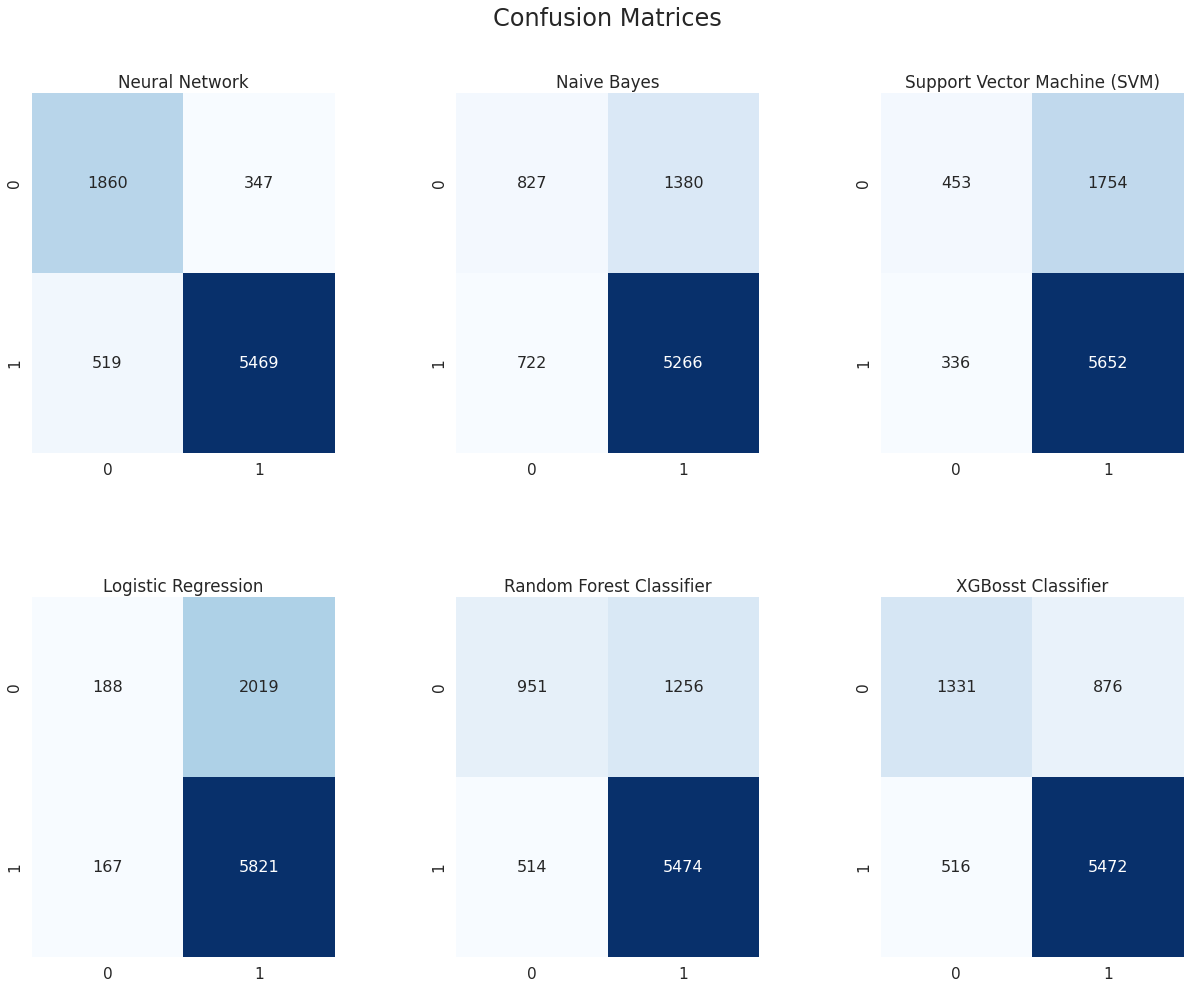

In [25]:
lr_cm=confusion_matrix(y_test, lr_preds )
nb_cm=confusion_matrix(y_test, nb_preds)
svm_cm=confusion_matrix(y_test, sv_preds)
nn_cm= confusion_matrix(y_test,y_preds)
rf_cm = confusion_matrix(y_test,rf_preds)
xg_cm = confusion_matrix(y_test,xg_preds)

plt.figure(figsize=(20,15))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,3,1)
plt.title("Neural Network")
sns.heatmap(nn_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');


plt.subplot(2,3,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,4)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,5)
plt.title("Random Forest Classifier")
sns.heatmap(rf_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,6)
plt.title("XGBosst Classifier")
sns.heatmap(xg_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

## ROC-AUC Curves Comparison

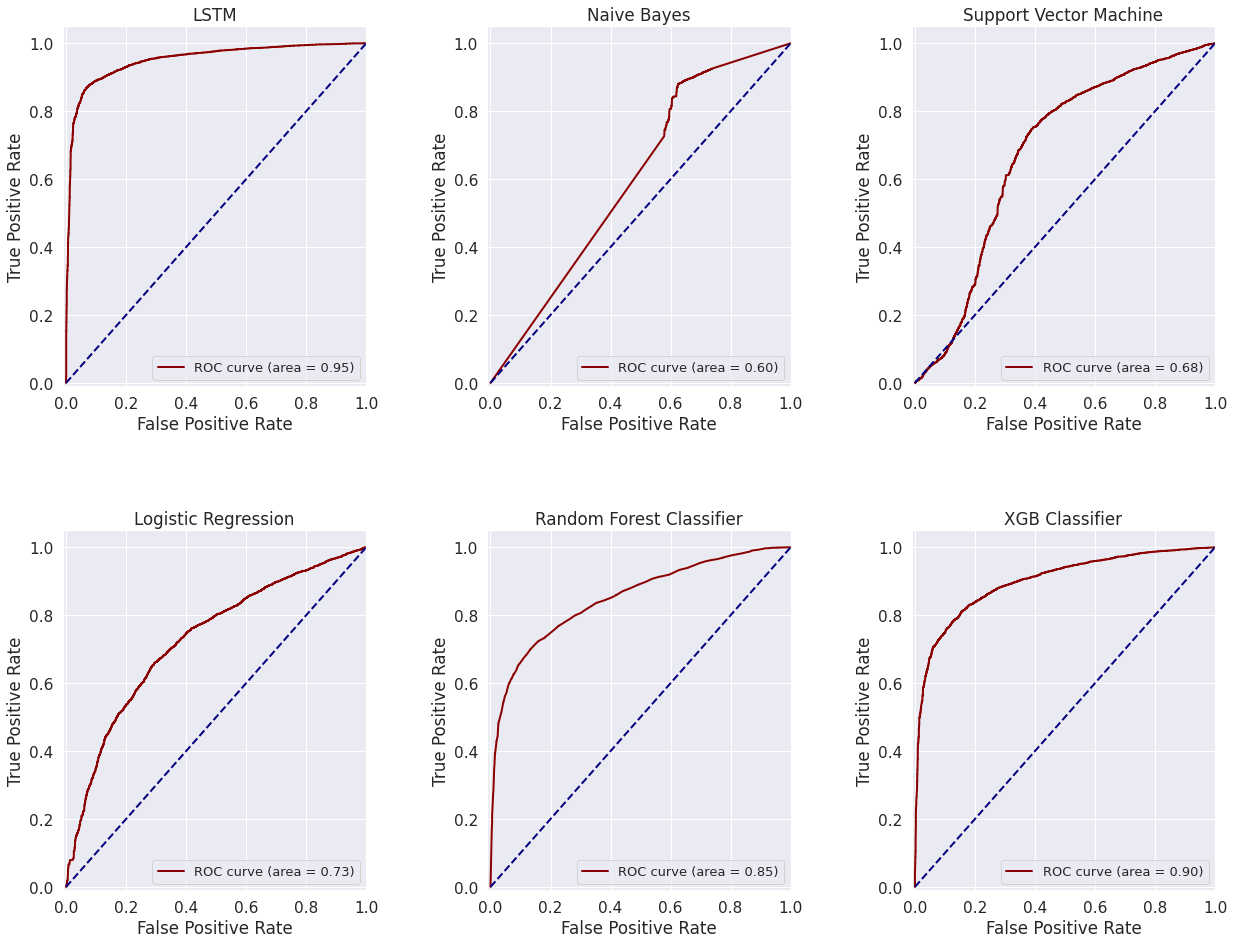

In [26]:
from sklearn.metrics import auc
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

fpr_nn, tpr_nn, _  = roc_curve(y_test, y_preds_prob)
roc_auc_nn = auc(fpr_nn,tpr_nn)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

f, axes = plt.subplots(2,3,figsize=(20,15))
axes[0,0].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'LSTM')
axes[0,0].legend(loc='lower right', fontsize=13);


axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[0,2].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[0,2].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[1,0].legend(loc='lower right', fontsize=13)


axes[1,1].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_rf))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[1,1].legend(loc='lower right', fontsize=13);


axes[1,2].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xg))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'XGB Classifier')
axes[1,2].legend(loc='lower right', fontsize=13);


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


# <center>If you find this notebook useful, support with an upvote👍</center>